In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline
 

## Abstraksi ##

**Problem Statement**: Diberikan dataset ("data_train.h5") berisikan:
    - training set dari m_train gambar yang dilabeli komodo (y=1),  jalakbali (y=0), lainnya (y=2)
    - test set dari m_test gambar yang dilabeli komodo atau jalakbali, atau lainnya
    - tiap gambar memiliki ukuran (num_px, num_px, 3), 3 berasal dari 3 channels (RGB). 

Algoritman ini merupakan pengenal gambar yang sederhana yang bisa mengklasifikasi gambar sebagai komodo atau jalakbali atau lainnya

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/data_train.h5', "r") # the training dataset
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('datasets/data_test.h5', "r") # the test dataset
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #  test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["animal"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Contoh gambar dari dataset:

y = [1], it's a 'komodo' picture.


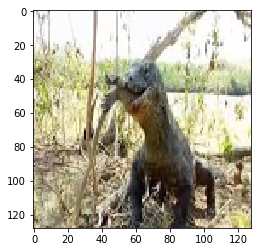

In [23]:
# Example of a picture
index = 202

plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Mencari nilai dari m_train, m_test, dan num_px <br/>
catatan: <br/>
`train_set_x_orig` adalah numpy-array dengan ukuran (m_train, num_px, num_px, 3).

In [7]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

Kita akan mengubah ukuran gambar dari training dan test data set dari (num_px, num_px, 3) ke vektor berukuran (num\_px $*$ num\_px $*$ 3, 1) agar mudah diproses

In [8]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

## Normalisasi data ##
Salah satu langkah umum preprocessing adalah memusatkan dan menormalisasi dataset, yang berarti bahwa mengurangi mean dari keseluruhan array numpy dari setiap sampel, kemudian membagi setiap sampel dengan standar deviasi dari seluruh array numpy. Tetapi untuk dataset gambar, lebih sederhana dan hasilnya hampir sama baik dengan langkah umum tadi, untuk membagi setiap baris dari dataset dengan 255 (nilai maksimum dari sebuah piksel).

In [9]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## Arsitektur umum dari algorima learning##

Yang akan kita buat adalah:
<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Expresi matematika dari algoritmanya**:

$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

cost:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Kuncinya adalah**:
    - Inisialisasi parameter dari model
    - Pelajari parameter untuk modelnya dengan meminimalkan cost  
    - Gunakan parameter yang sudah dipelajari untuk membuat prediksi (dari test set)
    - Analisis hasilnya dan simpulkan

In [10]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1+np.exp(-z))
    
    return s

### Inisialisasi Semua Parameter

In [11]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros([dim,1])
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

### Forward and Backward propagation

In [12]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    # compute activation
    cost = (-1.0/m)*(np.sum(Y*np.log(A)+(1-Y)*np.log(1-A)))         # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1.0/m)*(np.dot(X,(A-Y).T))
    db = (1.0/m)*np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Optimization

In [13]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.   
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [14]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[:,i] <= 0.5:
            Y_prediction[:,i] = 0
        elif A[:,i] <= 1.5:
            Y_prediction[:,i] = 1
        else :
            Y_prediction[:,i] = 2
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## Gabungkan semua fungsi ke dalam model ##

In [15]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.01, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
       
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

### Training the model

In [16]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

/opt/anaconda3/envs/ComputerVision/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/envs/ComputerVision/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


train accuracy: 68.7424425635 %
test accuracy: 11.6666666667 %


y = 2, you predicted that it is a "komodo" picture.


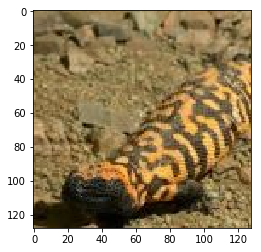

In [21]:
# Example
index = 101
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")
    


Plot cost function dan gradients.

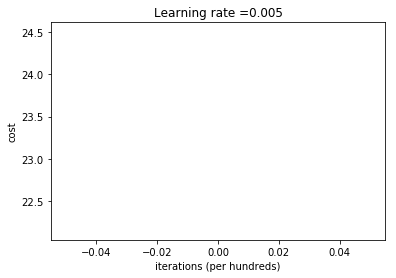

In [19]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()